# 유도변수: Q-vector
- 상승류를 유도하는 forcing
- https://unidata.github.io/python-training/gallery/850hpa_qvectors/

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

In [15]:
ds = xr.open_dataset('era5_pres_2020100600.nc')

In [24]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(60, 190)
lat_slice = slice(80, 0)

# Grab lat/lon values 
lats = ds.latitude.sel(latitude=lat_slice).values
lons = ds.longitude.sel(longitude=lon_slice).values

# Grab data and smooth using a nine-point filter applied 50 times to grab the synoptic signal
level = 850 * units.hPa
hght_850 = mpcalc.smooth_n_point(ds.z.sel(level=level, latitude=lat_slice, longitude=lon_slice).squeeze(), 9, 50) / 9.806
tmpk_850 = mpcalc.smooth_n_point(ds.t.sel(level=level, latitude=lat_slice, longitude=lon_slice).squeeze(), 9, 25)
uwnd_850 = mpcalc.smooth_n_point(ds.u.sel(level=level, latitude=lat_slice, longitude=lon_slice).squeeze(), 9, 50)
vwnd_850 = mpcalc.smooth_n_point(ds.v.sel(level=level, latitude=lat_slice, longitude=lon_slice).squeeze(), 9, 50)

# Convert temperatures to degree Celsius for plotting purposes
tmpc_850 = tmpk_850.to('degC')

# Get a sensible datetime format
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

In [25]:
# Compute grid spacings for data
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Compute the Q-vector components
uqvect, vqvect = mpcalc.q_vector(uwnd_850, vwnd_850, tmpk_850, 850*units.hPa, dx, dy)

# Compute the divergence of the Q-vectors calculated above
q_div = -2*mpcalc.divergence(uqvect, vqvect, dx, dy, dim_order='yx')

Text(1.0, 1.0, 'Valid Time: 2020-10-06 00:00:00')

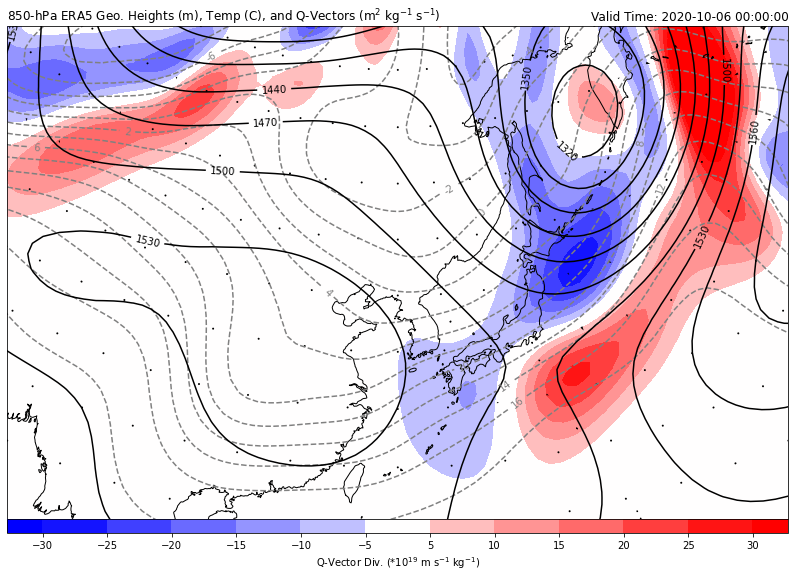

In [28]:
# Set the map projection (how the data will be displayed)
mapcrs = ccrs.LambertConformal(
    central_longitude=125, central_latitude=35, standard_parallels=(30, 60))

# Set the data project (ERA5 is lat/lon format)
datacrs = ccrs.PlateCarree()

# Start the figure and set an extent to only display a smaller graphics area
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add map features to plot coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 850-hPa Q-Vector Divergence and scale
clevs_850_tmpc = np.arange(-40, 41, 2)
clevs_qdiv = list(range(-30, -4, 5))+list(range(5, 31, 5))
cf = ax.contourf(lons, lats, q_div*1e19, clevs_qdiv, cmap=plt.cm.bwr,
                 extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True,
                  ticks=clevs_qdiv)
cb.set_label('Q-Vector Div. (*10$^{19}$ m s$^{-1}$ kg$^{-1}$)')

# Plot 850-hPa Temperatures
csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

# Plot 850-hPa Geopotential Heights
clevs_850_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_850, clevs_850_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 850-hPa Q-vectors, scale to get nice sized arrows
wind_slice = (slice(None, None, 5), slice(None, None, 5))
ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uqvect[wind_slice].m,
          vqvect[wind_slice].m,
          pivot='mid', color='black',
          scale=1e-11, scale_units='inches',
          transform=datacrs)

# Add some titles
plt.title('850-hPa ERA5 Geo. Heights (m), Temp (C),'
          ' and Q-Vectors (m$^2$ kg$^{-1}$ s$^{-1}$)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')